In [49]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os

from mvl2 import genData2
from mvl2.infer import *

set_platform('gpu')

import jax
from jax import numpy as jnp
import jax.numpy as jnp
from jax import random, vmap, pmap

import matplotlib.pyplot as plt

import numpy as np

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Predictive
from numpyro.infer.autoguide import *
from numpyro.infer.elbo import TraceGraph_ELBO

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import norm

from torch import tensor

random_seed = 9939
random_key = random.PRNGKey(random_seed)

Inv_Cumulative_Normal = norm.ppf

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

tensor([9.9688e-05, 9.9688e-05, 9.9688e-05, 9.9688e-05], dtype=torch.float64)
mean affects 1 tensor([9.9087e-05, 1.0012e-04, 2.0046e-04, 2.0046e-04], dtype=torch.float64)
std affects 1 tensor([9.7636e-05, 9.8663e-05, 1.9896e-04, 1.9896e-04], dtype=torch.float64)
mean affects 2 tensor([9.7609e-05, 3.0513e-04, 2.0364e-04, 6.2369e-04], dtype=torch.float64)
std affects 2 tensor([9.8568e-05, 3.2026e-04, 2.1182e-04, 6.8415e-04], dtype=torch.float64)
mean affects 3 tensor([9.7954e-05, 3.0005e-04, 1.0002e-04, 3.0005e-04], dtype=torch.float64)
std affects 3 tensor([9.9005e-05, 3.0320e-04, 1.0108e-04, 3.0320e-04], dtype=torch.float64)
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


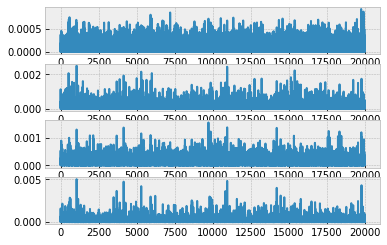

In [3]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_data = genData2.gen_counts(**sim_params)
sim_data["PVDs"].mean(0)

print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))

fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [4]:
random_key, _random_key = random.split(random_key)

run_params = {
    "data": sim_data["alt_counts"].numpy(),
    "max_K": 4,
}

mcmc_rs = run_until_enough(random_key=_random_key, run_params=run_params)

best_chain_rs, statistics_rs = select_best_chain(mcmc_rs)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_rs, best_probs_rs, _, _ = get_parameters(best_chain_rs)
H_rs, mean_df_rs = get_assumed_order_for_2(best_probs_rs, prevalences=sim_params['PD'], data=run_params['data'])
best_weights_rs, best_probs_rs, best_betas_rs, best_dirichlet_concentrations_rs = ordered_statistics([best_chain_rs], H_rs)

print("best chain's weight mean", best_weights_rs.mean(0))
print("best chain's probs mean", best_probs_rs.mean(0))

sample: 100%|██████████| 6000/6000 [00:45<00:00, 131.48it/s, 15 steps of size 2.44e-01. acc. prob=0.90] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.70      0.02      0.70      0.66      0.73   1283.39      1.00
                     beta[1]      0.18      0.03      0.18      0.13      0.23   1716.60      1.00
                     beta[2]      0.48      0.05      0.48      0.40      0.55   1360.84      1.00
dirichlet_concentration[0,0]      1.81      1.25      1.54      0.09      3.50   4843.18      1.00
dirichlet_concentration[0,1]      0.94      0.74      0.77      0.01      1.93   6861.16      1.00
dirichlet_concentration[0,2]      0.95      0.69      0.80      0.02      1.88   5350.02      1.00
dirichlet_concentration[0,3]      0.51      0.44      0.40      0.00      1.10   6083.12      1.00
dirichlet_concentration[1,0]      1.35      0.91      1.17      0.07      2.60   5001.72      1.00
dirichlet_concentration[1,1]      1.30      1.03      1.05      0.01      2.67   5641.53      1.00
dirichlet

sample: 100%|██████████| 6000/6000 [00:49<00:00, 121.56it/s, 31 steps of size 2.13e-01. acc. prob=0.93] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.12      0.02      0.12      0.09      0.16   1330.82      1.00
                     beta[1]      0.06      0.01      0.06      0.05      0.07   1476.48      1.00
                     beta[2]      0.84      0.01      0.84      0.83      0.86   1598.25      1.00
dirichlet_concentration[0,0]      1.63      1.11      1.41      0.07      3.11   4685.32      1.00
dirichlet_concentration[0,1]      0.89      0.68      0.74      0.01      1.79   4586.12      1.00
dirichlet_concentration[0,2]      1.23      0.92      1.03      0.04      2.44   5029.66      1.00
dirichlet_concentration[0,3]      0.60      0.51      0.47      0.00      1.29   4256.28      1.00
dirichlet_concentration[1,0]      1.33      0.90      1.15      0.08      2.61   4089.08      1.00
dirichlet_concentration[1,1]      1.30      1.00      1.05      0.01      2.64   4971.01      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12397123 0.05417011 0.6935385  0.12831911]
probs.mean(0) [[0.4774459  0.1556535  0.29358342 0.07331721]
 [0.3037423  0.31210446 0.21071702 0.17343627]
 [0.6011463  0.17412491 0.17652453 0.04820437]
 [0.4085542  0.369998   0.12545225 0.0959956 ]]


sample: 100%|██████████| 6000/6000 [00:46<00:00, 128.94it/s, 15 steps of size 2.42e-01. acc. prob=0.91]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.13      0.01      0.13      0.11      0.14   2123.56      1.00
                     beta[1]      0.80      0.02      0.81      0.76      0.84   1395.46      1.00
                     beta[2]      0.32      0.05      0.32      0.24      0.40   1424.41      1.00
dirichlet_concentration[0,0]      1.53      1.02      1.32      0.05      2.92   5362.19      1.00
dirichlet_concentration[0,1]      1.42      1.10      1.17      0.03      2.88   5289.97      1.00
dirichlet_concentration[0,2]      0.85      0.63      0.70      0.05      1.70   5394.36      1.00
dirichlet_concentration[0,3]      0.70      0.59      0.54      0.00      1.54   6107.63      1.00
dirichlet_concentration[1,0]      1.82      1.21      1.55      0.10      3.53   5874.59      1.00
dirichlet_concentration[1,1]      0.92      0.69      0.76      0.02      1.88   5391.63      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12884633 0.7001794  0.05394251 0.11703204]
probs.mean(0) [[0.40853742 0.369723   0.1256992  0.09604046]
 [0.6004479  0.17405097 0.1771501  0.04835111]
 [0.30362797 0.31176552 0.21100585 0.17360069]
 [0.47475982 0.15500014 0.2965595  0.07368059]]


sample: 100%|██████████| 6000/6000 [00:48<00:00, 124.08it/s, 15 steps of size 2.50e-01. acc. prob=0.89] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.70      0.02      0.70      0.66      0.73   1162.88      1.00
                     beta[1]      0.40      0.04      0.40      0.33      0.47   1216.22      1.00
                     beta[2]      0.71      0.04      0.71      0.64      0.77   2012.48      1.00
dirichlet_concentration[0,0]      1.78      1.19      1.53      0.12      3.45   6157.23      1.00
dirichlet_concentration[0,1]      0.92      0.72      0.72      0.01      1.90   6559.64      1.00
dirichlet_concentration[0,2]      0.94      0.70      0.78      0.01      1.88   6530.39      1.00
dirichlet_concentration[0,3]      0.51      0.42      0.39      0.00      1.07   6396.40      1.00
dirichlet_concentration[1,0]      1.62      1.10      1.39      0.08      3.20   5697.04      1.00
dirichlet_concentration[1,1]      0.88      0.68      0.72      0.01      1.82   6376.55      1.00
dirichlet

In [5]:
random_key, _random_key = random.split(random_key)

run_params_shared_prior = run_params.copy()
run_params_shared_prior["shared_dirichlet_prior"] = True

mcmc_rs_simple = run_until_enough(random_key=_random_key, run_params=run_params_shared_prior)

best_chain_rs_simple, statistics_rs_simple = select_best_chain(mcmc_rs_simple)
display(statistics_rs_simple)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_rs_simple, best_probs_rs_simple, _, _ = get_parameters(best_chain_rs_simple)
H_rs_simple, mean_df_rs_simple = get_assumed_order_for_2(best_probs_rs_simple, prevalences=sim_params['PD'], data=run_params['data'])
best_weights_rs_simple, best_probs_rs_simple, best_betas_rs_simple, best_dirichlet_concentrations_rs_simple = ordered_statistics([best_chain_rs_simple], H_rs_simple)

display(mean_df_rs_simple)
print("best chain's weight mean", best_weights_rs_simple.mean(0))
print("best chain's probs mean", best_probs_rs_simple.mean(0))

sample: 100%|██████████| 6000/6000 [00:41<00:00, 144.48it/s, 15 steps of size 2.42e-01. acc. prob=0.92]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.12      0.02      0.12      0.09      0.16   1559.07      1.00
                   beta[1]      0.15      0.01      0.15      0.13      0.17   1925.64      1.01
                   beta[2]      0.93      0.01      0.93      0.92      0.94   2147.96      1.00
dirichlet_concentration[0]      3.09      1.28      2.95      1.07      5.04   2739.02      1.00
dirichlet_concentration[1]      1.94      0.84      1.83      0.64      3.20   2996.15      1.00
dirichlet_concentration[2]      1.68      0.72      1.59      0.55      2.77   2760.17      1.00
dirichlet_concentration[3]      1.00      0.46      0.93      0.25      1.66   3814.26      1.00
                probs[0,0]      0.48      0.01      0.48      0.46      0.50   2138.59      1.00
                probs[0,1]      0.16      0.01      0.16      0.15      0.17   4169.55      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12453873 0.1300562  0.6924726  0.05293299]
probs.mean(0) [[0.47735098 0.15592231 0.2934452  0.07328154]
 [0.40858772 0.3692142  0.1260771  0.09612099]
 [0.60129297 0.17403638 0.17647648 0.04819417]
 [0.30292872 0.31174558 0.2111831  0.17414258]]


sample: 100%|██████████| 6000/6000 [00:41<00:00, 146.11it/s, 31 steps of size 2.34e-01. acc. prob=0.92]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.13      0.02      0.12      0.09      0.16   1344.12      1.00
                   beta[1]      0.15      0.01      0.15      0.13      0.17   1788.07      1.00
                   beta[2]      0.93      0.01      0.93      0.92      0.94   1643.41      1.00
dirichlet_concentration[0]      3.11      1.29      2.94      1.16      5.13   2933.61      1.00
dirichlet_concentration[1]      1.97      0.86      1.85      0.68      3.36   3232.36      1.00
dirichlet_concentration[2]      1.69      0.73      1.58      0.51      2.75   3061.53      1.00
dirichlet_concentration[3]      1.01      0.46      0.94      0.31      1.72   3552.81      1.00
                probs[0,0]      0.48      0.01      0.48      0.46      0.49   2019.02      1.00
                probs[0,1]      0.16      0.01      0.16      0.15      0.17   4082.97      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12529597 0.12985566 0.69195235 0.05289524]
probs.mean(0) [[0.47744888 0.15601885 0.2932067  0.0733256 ]
 [0.4084801  0.3693666  0.12603018 0.09612311]
 [0.60132843 0.17407191 0.17641586 0.04818387]
 [0.30286515 0.31191853 0.21094626 0.17427006]]


sample: 100%|██████████| 6000/6000 [00:38<00:00, 157.27it/s, 7 steps of size 2.79e-01. acc. prob=0.89] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.12      0.02      0.12      0.09      0.16   1727.68      1.00
                   beta[1]      0.15      0.01      0.15      0.13      0.17   2163.87      1.00
                   beta[2]      0.07      0.01      0.07      0.06      0.09   1658.22      1.00
dirichlet_concentration[0]      3.09      1.28      2.92      0.97      4.93   3162.57      1.00
dirichlet_concentration[1]      1.93      0.84      1.80      0.60      3.20   3394.40      1.00
dirichlet_concentration[2]      1.66      0.70      1.57      0.56      2.72   3139.58      1.00
dirichlet_concentration[3]      0.99      0.44      0.93      0.31      1.67   4376.73      1.00
                probs[0,0]      0.48      0.01      0.48      0.46      0.50   2287.70      1.00
                probs[0,1]      0.16      0.01      0.16      0.15      0.17   4303.73      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12479217 0.12939446 0.05363111 0.69218224]
probs.mean(0) [[0.4775879  0.15576185 0.29340133 0.07324895]
 [0.40858838 0.36946595 0.1259002  0.09604553]
 [0.3033534  0.31157917 0.21114479 0.1739227 ]
 [0.6012928  0.17411064 0.17641671 0.04817991]]


sample: 100%|██████████| 6000/6000 [00:39<00:00, 150.61it/s, 15 steps of size 2.43e-01. acc. prob=0.91]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.70      0.02      0.70      0.67      0.73   1469.39      1.00
                   beta[1]      0.18      0.03      0.18      0.14      0.23   1670.47      1.00
                   beta[2]      0.53      0.05      0.53      0.45      0.60   1513.76      1.00
dirichlet_concentration[0]      3.03      1.22      2.87      1.12      4.94   3206.07      1.00
dirichlet_concentration[1]      1.91      0.81      1.81      0.60      3.14   3594.54      1.00
dirichlet_concentration[2]      1.65      0.70      1.56      0.57      2.74   3703.50      1.00
dirichlet_concentration[3]      0.98      0.44      0.92      0.33      1.69   3966.21      1.00
                probs[0,0]      0.60      0.00      0.60      0.60      0.60   1904.77      1.00
                probs[0,1]      0.17      0.00      0.17      0.17      0.18   4093.22      1.00
                probs[0,2]   

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
1,0.0,0.924423,0.080511,436522.34375,1.0
0,0.0,0.918741,0.085968,436523.43750,0.0
3,0.0,0.908514,0.095672,436517.34375,3.0
2,0.0,0.894246,0.107227,436528.59375,2.0


,"P(~D|V,H)","P(D1|V,H)","P(D2|V,H)","P(D12|V,H)"
H2,0.477351,0.155922,0.293445,0.073282
H1,0.408588,0.369214,0.126077,0.096121
H0,0.601293,0.174036,0.176476,0.048194
H12,0.302929,0.311746,0.211183,0.174143


best chain's weight mean [0.6924726  0.1300562  0.12453873 0.05293299]
best chain's probs mean [[0.60129327 0.1740363  0.17647657 0.04819423]
 [0.40858772 0.36921415 0.12607703 0.09612115]
 [0.47735083 0.1559223  0.29344514 0.07328141]
 [0.30292875 0.31174564 0.21118315 0.17414255]]


In [6]:
import pandas as pd
import numpy as np
df = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv')

#df = pd.read_csv('/home/akotlar/tada/project/sim/test_dave3.csv')
pds = np.array([0.022515,0.02302,0.001295])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "max_K": 4,
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

mcmc_dave_2k_8k_gamma8 = run_until_enough(random_key=_random_key, run_params=run_params_dave)
best_chain, statistics = select_best_chain(mcmc_dave_2k_8k_gamma8)
display(statistics)
del mcmc_dave_2k_8k_gamma8

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights, best_probs, _, _ = get_parameters(best_chain)
H, mean_df = get_assumed_order_for_2(best_probs, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'], data=stat_data_dave, prevalences=pds)
best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain], order=H)

best_probs_mean_across_mcmc_samples = np.array(best_probs.mean(0))
best_weights_mean_across_mcmc_samples = np.array(best_weights.mean(0))

display('best_probs sample mean', best_probs.mean(0))
display('best_weights sample mean', best_weights.mean(0))

display(mean_df)

sample: 100%|██████████| 6000/6000 [05:49<00:00, 17.16it/s, 255 steps of size 1.75e-02. acc. prob=0.90] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.09      0.01      0.09      0.07      0.12   1234.51      1.00
                     beta[1]      0.12      0.02      0.12      0.09      0.15   2081.46      1.00
                     beta[2]      0.95      0.02      0.95      0.93      0.98    751.42      1.00
dirichlet_concentration[0,0]      6.22      1.02      6.17      4.49      7.82   5505.30      1.00
dirichlet_concentration[0,1]      0.79      0.53      0.69      0.02      1.49   5820.42      1.00
dirichlet_concentration[0,2]      0.89      0.61      0.77      0.04      1.75   4805.20      1.00
dirichlet_concentration[0,3]      0.34      0.31      0.25      0.00      0.74   5997.71      1.00
dirichlet_concentration[1,0]      6.22      1.01      6.17      4.59      7.89   5361.12      1.00
dirichlet_concentration[1,1]      0.88      0.58      0.77      0.06      1.69   5763.76      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.09345752 0.1109505  0.75740397 0.03818886]
probs.mean(0) [[0.88095623 0.04514338 0.06689208 0.00700832]
 [0.904638   0.06614301 0.02464356 0.00457548]
 [0.95427424 0.02245582 0.0218713  0.00139871]
 [0.92267996 0.00819086 0.06797566 0.00115355]]


sample:  60%|██████    | 3606/6000 [09:43<06:27,  6.18it/s, 1023 steps of size 4.04e-03. acc. prob=0.91]


KeyboardInterrupt: 

In [ ]:
run_params_dave_simple = {
    "data": stat_data_dave,
    "max_K": 4,
    'shared_dirichlet_prior': True
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

mcmc_dave_2k_8k_gamma8_simple = run_until_enough(random_key=_random_key, run_params=run_params_dave_simple)
best_chain_simple, statistics_simple = select_best_chain(mcmc_dave_2k_8k_gamma8_simple)
display(statistics_simple)
del mcmc_dave_2k_8k_gamma8_simple

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_simple, best_probs_simple, _, _ = get_parameters(best_chain_simple)
H_simple, mean_df_simple = get_assumed_order_for_2(best_probs_simple, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'], data=stat_data_dave, prevalences=pds)
best_weights_simple, best_probs_simple, best_betas_simple, best_dirichlet_concentrations_simple = ordered_statistics([best_chain_simple], order=H_simple)

display('best_probs sample mean',best_probs_simple.mean(0))
display('best_weights sample mean', best_weights_simple.mean(0))

display(mean_df)

In [ ]:
run_params_dave_simple = {
    "data": stat_data_dave,
    "max_K": 4,
    'shared_dirichlet_prior': False
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

mcmc_dave_2k_8k_gamma8_simple = run_until_enough(random_key=_random_key, run_params=run_params_dave_simple)
best_chain_simple, statistics_simple = select_best_chain(mcmc_dave_2k_8k_gamma8_simple)
display(statistics_simple)
del mcmc_dave_2k_8k_gamma8_simple

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_simple, best_probs_simple, _, _ = get_parameters(best_chain_simple)
H_simple, mean_df_simple = get_assumed_order_for_2(best_probs_simple, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'], data=stat_data_dave, prevalences=pds)
best_weights_simple, best_probs_simple, best_betas_simple, best_dirichlet_concentrations_simple = ordered_statistics([best_chain_simple], order=H_simple)

display('best_probs sample mean',best_probs_simple.mean(0))
display('best_weights sample mean', best_weights_simple.mean(0))

display(mean_df)

In [ ]:
best_weights, best_probs, _, _ = get_parameters(best_chain)
H, mean_df = get_assumed_order_for_2(best_probs, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'])
best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain], order=H)

best_probs_mean_across_mcmc_samples = np.array(best_probs.mean(0))
best_weights_mean_across_mcmc_samples = np.array(best_weights.mean(0))

display('best_probs sample mean',best_probs_mean_across_mcmc_samples)
display('best_weights sample mean', best_weights_mean_across_mcmc_samples)

display(mean_df)

In [ ]:
H_based_on_pis = [0,3,2,1]
print("H", H)
print("H_based_on_pis", H_based_on_pis)

print("best_weights.mean(0)", best_weights.mean(0))

print("best_weights.mean(0)[H]", best_weights.mean(0)[H])

print("best_weights.mean(0)[H_based_on_pis]", best_weights.mean(0)[H_based_on_pis])

print("\nbest_probs.mean(0)", best_probs.mean(0))
print("best_probs.mean(0)[H]", best_probs.mean(0)[H])
print("best_probs.mean(0)[H_based_on_pis]", best_probs.mean(0)[H_based_on_pis])

PD_V_H_P_H_across_samples = np.multiply(best_probs, best_weights.reshape(*best_weights.shape,1))

PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)
print("\nPD_V_H_P_H_mean", PD_V_H_P_H_mean)
print("ordered PD|Vs based on H", PD_V_H_P_H_mean[H])
print("ordered PD|Vs based on H_based_on_pis", PD_V_H_P_H_mean[H_based_on_pis])
        
PD_V = PD_V_H_P_H_mean[H_based_on_pis].sum(1)
display("PD|V", PD_V)
PD = np.array([0.022515,0.02302,0.001295])
PV = q = 1e-4

rr = PD_V[1:4]/PD
display("rr",rr)

In [ ]:
df.sum(1)

In [ ]:
(df['Per_Gene_Counts_Unaffected_Unaffected'] / df.sum(1)).mean(0)

In [ ]:
(df['Affected_Unaffected'] / df.sum(1)).mean(0)

In [ ]:
(df['Unaffected_Affected'] / df.sum(1)).mean(0)

In [ ]:
(df['Affected_Affected'] / df.sum(1)).mean(0)

In [ ]:
df['Affected_Unaffected'].mean(0)

In [ ]:
df['Affected_Affected'].mean(0)

In [ ]:
P_D1_A1 = PD_V[1]
P_D2_A1 = PD_V[2]
print("P_D1_A1", P_D1_A1)
print("P_D2_A1", P_D2_A1)
q = 1e-4
p = 1-q

#Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.022515,0.02302,0.001295
prevalence_d1 = PD[0]#.02
prevalence_d2 = PD[0] #.02
thresh1 = Inv_Cumulative_Normal(PD[1])
thresh2 = Inv_Cumulative_Normal(prevalence_d2)
print(f"thresh1: {thresh1}, thresh2: {thresh2}")

alpha1_D1 = thresh1 - Inv_Cumulative_Normal( 1- P_D1_A1)
alpha1_D2 = thresh2 - Inv_Cumulative_Normal( 1- P_D2_A1)

alpha2_D1 = -p*alpha1_D1/q
alpha2_D2 = -p*alpha1_D2/q

variance_D1 = 2*(p*(alpha1_D1**2) + q * (alpha2_D1**2))
variance_D2 = 2*(p*(alpha1_D2**2) + q * (alpha2_D2**2))
print(f"alpha2_D1: {alpha2_D1}, alpha2_D2: {alpha2_D2}")
print(f"variance_D1: {variance_D1}, variance_D2: {variance_D2}")

cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
print(f"cov: {cov}")

rho = cov / ((variance_D1*variance_D2)**.5)
print(f"rho: {rho}")

In [ ]:
# For a locus with two alleles, A1 and A2, with frequencies p and q.

# alpha1 = (Freq(A1A1) * Average(Phenotype of A1A1 individuals) +
# 1/2 *Freq(A1A2) * Average(Phenotype of A1A2 individuals) ) / p

# alpha2 = -p * alpha1 /q

# For case control data, if the prevalence of disease is Pv, then
# the threshold on the liability scale is

# thres =  Inv_Cumulatative_Normal( 1 - Pv)

# If the penetrance of A1 is P{D | A1}. then 

# alpha1 = thres - Inv_Cumulative_Normal( 1- P{D | A1})

# i..e alpha1 is the mean liability of individuals with an A1 allele.

# alpha2 = -p*alpha / q

# Va due to the locus is 2*(p*alpha1^2 + q*alpha2)

# Of course, with two phenotypes you can calculate the alphas independently
# for the two traits based on the penetrance of the A1 allele for both traits.

# For your problem, we can think of A1 is the collection of a bunch of 
# rare alleles....

P_D_V = PD_V[1:4].sum()
thres =  Inv_Cumulatative_Normal( 1 - Pv)


In [ ]:
def plot_regression(x, y_mean, y_hpdi):
    print(x.shape)
    # Sort values for plotting by x axis
    # idx = jnp.argsort(x)
    # marriage = x[idx]
    ctrls = stat_data_dave[:, 0]
    print('ctrls.shape', ctrls.shape)
    case1 = stat_data_dave[:, 1]
    case2 = stat_data_dave[:, 2]
    caseBoth  = stat_data_dave[:, 3]
    
    
    meanCtrls = y_mean[:, 0]
    print('meanCtrls.shape', meanCtrls.shape)
    print("y_hpdi.shape", y_hpdi.shape)
    meanCtrls = y_mean[:, 1]
    meanCtrls = y_mean[:, 2]
    meanCtrls = y_mean[:, 3]
    hpdiCtrls = y_hpdi[:, 0]
    hpdiCases1 = y_hpdi[:, 1]
    hpdiCases2 = y_hpdi[:, 2]
    hpdiCasesBoth = y_hpdi[:, 3]

    # Plot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
    ax.plot(ctrls, meanCtrls)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

random_key, _random_key = random.split(random_key)
t = best_chain.get_samples()
# test = {
#     'beta': t['beta'][0,:],
#     'dirichlet_concentration': t['dirichlet_concentration'][0,:],
#     'probs': t['probs'][0,:]}

prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(_random_key, stat_data_dave,n_cases,n_ctrls,4)[
    "obs"
]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)
ax = plot_regression(stat_data_dave, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Obs", ylabel="Divorce rate", title="Predictions with 90% CI");
# predictive = Predictive(model_with_gamma_prior_alpha8, t)


# samples_predictive = predictive(random.PRNGKey(1), stat_data_dave,n_cases,n_ctrls,4)

# mean_prior_pred = jnp.mean(samples_predictive, axis=0)
# hpdi_prior_pred = hpdi(prior_predictions, 0.9)
# # display(samples_predictive['z'].mean(0)[0:100])
# pd.DataFrame(np.array(samples_predictive['z'])[0], columns=['z']).to_csv("z_pred.tsv", sep='\t')
# display(np.array(samples_predictive['z'])[0:3])
# display(np.array(samples_predictive['obs'])[1999])
# posterior_samples = best_chain.get_samples()
# predictive = Predictive(model, posterior_samples=posterior_samples)
# samples = predictive(_random_key, *model_args)
# print(samples)

# weights, probs, betas, dirichlet_concentrations = ordered_statistics([best_chain])

# assumed_h0, assumed_h1, assumed_h2, assumed_h12, mean_df = get_assumed_order_for_2(best_probs, best_weights)
# display(mean_df)

# PD_V_H_P_H_across_samples = np.multiply(probs, weights.reshape(*weights.shape,1))


# PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)[np.array([assumed_h0, assumed_h1, assumed_h2, assumed_h12])]

# PD_V = PD_V_H_P_H_mean.sum(1)

# rr = PD_V[1:4]/PD
# display(rr)

In [ ]:
from numpyro.infer.util import Predictive
PD = np.array([0.022515,0.02302,0.001295])
PV = q = 1e-4
model_args = [run_params_dave['data'], run_params_dave['n_cases'], run_params_dave['n_ctrls'], run_params_dave['max_K']]
i = 0
while i < 20_000:
    i += 1
    
    random_key, _random_key = random.split(random_key)
    predictive = Predictive(new_school, best_chain.get_samples())
    samples_predictive = predictive(random.PRNGKey(1))
    print(np.mean(samples_predictive['obs'])) 
    posterior_samples = best_chain.get_samples()
    predictive = Predictive(model, posterior_samples=posterior_samples)
    samples = predictive(_random_key, *model_args)
    print(samples)

    weights, probs, betas, dirichlet_concentrations = ordered_statistics([best_chain])
    
    assumed_h0, assumed_h1, assumed_h2, assumed_h12, mean_df = get_assumed_order_for_2(best_probs, best_weights)
    display(mean_df)
    
    PD_V_H_P_H_across_samples = np.multiply(probs, weights.reshape(*weights.shape,1))
    

    PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)[np.array([assumed_h0, assumed_h1, assumed_h2, assumed_h12])]

    PD_V = PD_V_H_P_H_mean.sum(1)

    rr = PD_V[1:4]/PD
    display(rr)
    
    if i > 5:
        break

    # For a locus with two alleles, A1 and A2, with frequencies p and q.

    # alpha1 = (Freq(A1A1) * Average(Phenotype of A1A1 individuals) +
    # 1/2 *Freq(A1A2) * Average(Phenotype of A1A2 individuals) ) / p

    # alpha2 = -p * alpha1 /q

    # For case control data, if the prevalence of disease is Pv, then
    # the threshold on the liability scale is

    # thres =  Inv_Cumulatative_Normal( 1 - Pv)

    # If the penetrance of A1 is P{D | A1}. then 

    # alpha1 = thres - Inv_Cumulative_Normal( 1- P{D | A1})

    # i..e alpha1 is the mean liability of individuals with an A1 allele.

    # alpha2 = -p*alpha / q

    # Va due to the locus is 2*(p*alpha1^2 + q*alpha2)

    # Of course, with two phenotypes you can calculate the alphas independently
    # for the two traits based on the penetrance of the A1 allele for both traits.

    # For your problem, we can think of A1 is the collection of a bunch of 
    # rare alleles....

    # Assuming alpha is our rare allele marginal sums (per gene), across all samples:
#     P_D1_A1 = PD_V[1]
#     P_D2_A1 = PD_V[2]
#     print("P_D1_A1", P_D1_A1)
#     print("P_D2_A1", P_D2_A1)
#     q = 1e-4
#     p = 1-q

#     #Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.022515,0.02302,0.001295
#     prevalence_d1 = PD[0]#.02
#     prevalence_d2 = PD[0] #.02
#     thresh1 = Inv_Cumulative_Normal(PD[1])
#     thresh2 = Inv_Cumulative_Normal(prevalence_d2)
#     print(f"thresh1: {thresh1}, thresh2: {thresh2}")

#     alpha1_D1 = thresh1 - Inv_Cumulative_Normal( 1- P_D1_A1)
#     alpha1_D2 = thresh2 - Inv_Cumulative_Normal( 1- P_D2_A1)

#     alpha2_D1 = -p*alpha1_D1/q
#     alpha2_D2 = -p*alpha1_D2/q

#     variance_D1 = 2*(p*(alpha1_D1**2) + q * (alpha2_D1**2))
#     variance_D2 = 2*(p*(alpha1_D2**2) + q * (alpha2_D2**2))
#     print(f"alpha2_D1: {alpha2_D1}, alpha2_D2: {alpha2_D2}")
#     print(f"variance_D1: {variance_D1}, variance_D2: {variance_D2}")

#     cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
#     print(f"cov: {cov}")

#     rho = cov / ((variance_D1*variance_D2)**.5)
#     print(f"rho: {rho}")
#     break

In [ ]:
!cat sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv.ss

In [ ]:
# random_key, _random_key = random.split(random_key)
#P(H0|D) = P(D|H0)P(H0)
H0_posterior = (best_weights[0][:,assumed_h0] @ best_probs[0][:,assumed_h0]).mean(0).mean(0)
#P(H1|D) = P(D|H1)P(H1)


best_weights[0][:,assumed_h0].mean()

In [ ]:
plt.plot(best_chain.get_extra_fields()['potential_energy'])

In [3]:
import pandas as pd
import numpy as np

df_exp2 = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.8/results.csv')
# disorder 1, disorder 2, comorbid
pds_exp2 = np.array([0.03669,0.043745,0.00995])
pd_with_both_exp2 = np.array([1 - pds_exp2.sum(), *pds_exp2])
n_samples_exp2 = 200_000
n_cases_exp2 = n_samples_exp2 * pds_exp2
n_ctrls_exp2 = n_samples_exp2 - n_cases_exp2.sum()

display(df_exp2)

run_params_exp2 = {
    "data": df_exp2.to_numpy(),
    "max_K": 4,
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp2 = run_until_enough(random_key=_random_key, run_params=run_params_exp2)
best_chain_exp2, statistics_exp2 = select_best_chain(res_exp2)
display(statistics_exp2)
# del res_exp2

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp2, best_probs_exp2, best_dirichlet_concentrations_exp2, _ = get_parameters(best_chain_exp2)
# H_exp2, mean_df_exp2 = get_assumed_order_for_2(best_probs_exp2, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'])
# best_weights_exp2, best_probs_exp2, best_betas_exp2, best_dirichlet_concentrations_exp2 = ordered_statistics([best_chain_exp2], order=H_exp2)

# display(mean_df_exp2)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,50,1,4,0
1,41,1,0,0
2,37,1,2,0
3,31,2,6,1
4,42,1,2,1
...,...,...,...,...
19995,29,0,1,1
19996,39,1,0,1
19997,28,0,3,0
19998,36,2,1,0


sample: 100%|██████████| 6000/6000 [00:37<00:00, 158.94it/s, 7 steps of size 4.19e-01. acc. prob=0.86] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.04      0.05   3459.16      1.00
                     beta[1]      0.04      0.00      0.04      0.04      0.05   3170.59      1.00
                     beta[2]      0.96      0.00      0.96      0.96      0.96   3541.66      1.00
dirichlet_concentration[0,0]      5.47      0.99      5.40      3.89      7.10   4254.75      1.00
dirichlet_concentration[0,1]      1.53      1.00      1.33      0.08      2.95   4406.82      1.00
dirichlet_concentration[0,2]      0.50      0.37      0.41      0.01      0.99   4556.96      1.00
dirichlet_concentration[0,3]      0.55      0.43      0.45      0.01      1.13   4571.35      1.00
dirichlet_concentration[1,0]      5.45      0.97      5.40      3.88      6.98   4469.10      1.00
dirichlet_concentration[1,1]      1.25      0.86      1.07      0.04      2.46   5258.49      1.00
dirichlet

sample: 100%|██████████| 6000/6000 [00:40<00:00, 148.52it/s, 15 steps of size 2.80e-01. acc. prob=0.91]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.03      0.04   5156.36      1.00
                     beta[1]      0.04      0.00      0.04      0.04      0.05   6666.84      1.00
                     beta[2]      0.95      0.00      0.95      0.95      0.96   5839.49      1.00
dirichlet_concentration[0,0]      5.50      1.02      5.43      3.84      7.15   7622.70      1.00
dirichlet_concentration[0,1]      0.53      0.39      0.44      0.01      1.06   7623.75      1.00
dirichlet_concentration[0,2]      1.36      0.91      1.19      0.04      2.61   7857.09      1.00
dirichlet_concentration[0,3]      0.54      0.44      0.43      0.00      1.12   6789.28      1.00
dirichlet_concentration[1,0]      5.44      1.02      5.37      3.80      7.09   7770.78      1.00
dirichlet_concentration[1,1]      1.27      0.87      1.11      0.06      2.46   7694.96      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.03723424 0.0429673  0.87724316 0.04255478]
probs.mean(0) [[0.7664949  0.01660644 0.1897624  0.02713629]
 [0.6516818  0.14772844 0.09959592 0.10099383]
 [0.92727655 0.03450163 0.02787831 0.01034355]
 [0.7305276  0.23075478 0.01321055 0.02550716]]


sample: 100%|██████████| 6000/6000 [01:22<00:00, 72.61it/s, 7 steps of size 3.68e-01. acc. prob=0.88]  



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.03      0.04   4645.87      1.00
                     beta[1]      0.04      0.00      0.04      0.04      0.05   4624.14      1.00
                     beta[2]      0.95      0.00      0.95      0.95      0.96   4866.06      1.00
dirichlet_concentration[0,0]      5.53      0.99      5.47      3.87      7.12   5436.85      1.00
dirichlet_concentration[0,1]      0.53      0.39      0.43      0.01      1.04   5429.03      1.00
dirichlet_concentration[0,2]      1.38      0.91      1.22      0.07      2.64   5307.29      1.00
dirichlet_concentration[0,3]      0.53      0.43      0.43      0.01      1.12   5284.65      1.00
dirichlet_concentration[1,0]      5.46      0.98      5.39      3.91      7.05   5498.56      1.00
dirichlet_concentration[1,1]      1.52      0.99      1.32      0.15      2.95   5525.27      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.03725385 0.04266066 0.87726927 0.04281553]
probs.mean(0) [[0.7665239  0.01661657 0.1897043  0.02715524]
 [0.7306403  0.2306096  0.01322513 0.02552498]
 [0.9272759  0.03450302 0.02787784 0.01034326]
 [0.6515483  0.14776416 0.09963616 0.10105139]]


sample: 100%|██████████| 6000/6000 [00:44<00:00, 135.72it/s, 15 steps of size 3.13e-01. acc. prob=0.90]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.88      0.00      0.88      0.87      0.88   8985.08      1.00
                     beta[1]      0.30      0.01      0.30      0.29      0.32   6566.60      1.00
                     beta[2]      0.50      0.02      0.50      0.47      0.52   5564.59      1.00
dirichlet_concentration[0,0]      5.59      1.00      5.53      4.04      7.22   8974.40      1.00
dirichlet_concentration[0,1]      0.65      0.47      0.54      0.03      1.31   7631.42      1.00
dirichlet_concentration[0,2]      0.59      0.43      0.50      0.01      1.17   6969.10      1.00
dirichlet_concentration[0,3]      0.40      0.33      0.31      0.00      0.85   6743.67      1.00
dirichlet_concentration[1,0]      5.50      0.99      5.47      3.93      7.15   8447.05      1.00
dirichlet_concentration[1,1]      0.52      0.37      0.44      0.02      1.04   6675.27      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
1,0.0,0.906381,0.090982,2300072.5,1.0
3,0.0,0.901907,0.095699,2300066.0,3.0
2,0.0,0.882624,0.113058,2300067.0,2.0
0,0.0,0.857780,0.131228,2300074.0,0.0


In [7]:
best_weights_exp2, best_probs_exp2, best_betas_exp2, best_dirichlet_concentrations_exp2 = get_parameters(best_chain_exp2)


In [9]:
best_dirichlet_concentrations_exp2.mean(0)

DeviceArray([[5.470484  , 1.5275794 , 0.4979165 , 0.5451065 ],
             [5.4534163 , 1.254632  , 1.0242972 , 0.99051774],
             [5.602591  , 0.64033335, 0.59594107, 0.3955781 ],
             [5.4832716 , 0.53104216, 1.3449639 , 0.5459469 ]],            dtype=float32)

In [10]:
def ga(probs: np.ndarray, prevalences: np.ndarray = None, data: np.ndarray = None, data_columns: List[str] = ['unaffected', 'affected1', 'affected2', 'affected12']):
    """
    Infer the order of hypotheses for 2 conditions and 4 channels: ctrls, cases1, cases2, cases_both
    prevalences: Iterable[Union[int, float]]
        The list of prevalences for each of the condition columns (ex: ctrls, cases1, cases2, cases for both). Should be in the same order as the data columns
        The last element of the prevalences array should be comorbidity, if known
    """
    hypotheses = {}

    mapping= {
        'unaffected': 'P(~D|V,H)',
        'affected1': 'P(D1|V,H)',
        'affected2': 'P(D2|V,H)',
        'affected12': 'P(D12|V,H)'
    }
    
    poss = "0123"

    if prevalences is None:
        assert data is not None
        prevalences = (data/data.sum(1).reshape(data.shape[0], 1)).mean(0)
    probs_mean = probs.mean(0)
    probs_mean_df = pd.DataFrame(probs_mean, dtype='float32', columns=[mapping[x] for x in data_columns])

    pdiff = np.abs(probs_mean - prevalences)
    
    h0 = -1
    min_sum = 1
    idx = -1
    for row in pdiff:
        idx += 1
        s = row.sum()

        if s < min_sum:
            h0 = idx
            min_sum = s

    hypotheses[h0] = 'H0'
    
    h1 = (probs_mean_df['P(D1|V,H)'] - probs_mean_df['P(D2|V,H)']).idxmax()
    hypotheses[h1] = 'H1'

    h2 = (probs_mean_df['P(D2|V,H)'] - probs_mean_df['P(D1|V,H)']).idxmax()
    hypotheses[h2] = 'H2'
    
    h12 = (probs_mean_df['P(D12|V,H)']).idxmax()
    hypotheses[h12] = 'H12'

    probs_mean_df.index = [hypotheses[k] for k in probs_mean_df.index]
    
    return np.array([h0, h1, h2, h12]), probs_mean_df

order_h0_h1_h2_h12, probs_mean_df = ga(best_probs_exp2, data=df_exp2.to_numpy())
display(probs_mean_df)
print(best_probs_exp2.mean(0)[order_h0_h1_h2_h12])
# ordered_probs = best_dirichlet_concentrations_exp2

,"P(~D|V,H)","P(D1|V,H)","P(D2|V,H)","P(D12|V,H)"
H1,0.730614,0.230657,0.013218,0.025511
H12,0.651657,0.147714,0.099628,0.101000
H0,0.927278,0.034499,0.027879,0.010344
H2,0.766385,0.016587,0.189875,0.027154


[[0.92727786 0.03449934 0.02787906 0.01034378]
 [0.7306144  0.23065655 0.01321766 0.02551145]
 [0.7663849  0.01658704 0.18987462 0.02715351]
 [0.6516569  0.1477144  0.09962822 0.10100048]]


In [58]:
best_weights_exp2.mean(0)

array([0.04266028, 0.04295733, 0.8772195 , 0.03716154], dtype=float32)

In [81]:
from numpyro import handlers
from numpyro.distributions import *

mean_dir_conc = best_dirichlet_concentrations_exp2.mean(0)
mean_probs = probs_mean_df.to_numpy()
mean_weights = best_weights_exp2.mean(0)

with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    df_exp2_np = df_exp2.to_numpy()
    cases1_idx = 2
    cases2_idx = 1
    n_cases = 200_000
    
    variance_D1_sum = 0
    variance_D2_sum = 0
    cov_sum = 0

    mean_prevalences = (df_exp2_np / np.expand_dims(df_exp2_np.sum(1), axis=0).T).mean(0)

    prevalence_d1 = mean_prevalences[cases1_idx]
    prevalence_d2 = mean_prevalences[cases2_idx]
    
    i = 0
    d = Multinomial(probs=mean_probs)
    for obs in df_exp2.to_numpy():
#         log_probs = d.log_prob(obs)

#         hypothesis = np.argmax(log_probs)

        #version 1
        #posterior = (mean_dir_conc[hypothesis] + obs)/(obs.sum() + mean_dir_conc[hypothesis].sum())
        #P_D1_A1 = posterior[cases1_idx]
        #P_D2_A1 = posterior[cases2_idx]
        
        # version 2
        # P_D1_A1 = mean_probs[hypothesis][cases1_idx]
        # P_D2_A1 = mean_probs[hypothesis][cases2_idx]
        
        # version 3; take posterior averaged over all components
        posterior = np.multiply(mean_weights, (mean_dir_conc + obs)/(obs.sum() + mean_dir_conc.sum(1)))
        # print("mean_weights", mean_weights)
        # print((mean_dir_conc + obs)/(obs.sum() + mean_dir_conc.sum(1)))
        # print(posterior)
        P_D1_A1 = posterior[cases1_idx].sum(0)
        P_D2_A1 = posterior[cases2_idx].sum(0)
        q = obs.sum() / (n_cases*2)
        p = 1-q
        
        thresh1 = Inv_Cumulative_Normal(1 - prevalence_d1)
        thresh2 = Inv_Cumulative_Normal(1 - prevalence_d2)

        alpha1_D1 = thresh1 - Inv_Cumulative_Normal(1 - P_D1_A1)
        alpha1_D2 = thresh2 - Inv_Cumulative_Normal(1 - P_D2_A1)
        
        alpha2_D1 = -p*alpha1_D1/q
        alpha2_D2 = -p*alpha1_D2/q
        
        variance_D1 = 2*(p*(alpha1_D1**2) + q*(alpha2_D1**2))
        variance_D2 = 2*(p*(alpha1_D2**2) + q*(alpha2_D2**2))
        
        variance_D1_sum += variance_D1
        variance_D2_sum += variance_D2
        
        cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
        
        cov_sum += cov
          
#         print('obs', obs)
#         print('posterior', posterior)
#         print('hypothesis', hypothesis)
#         print('mean_dir_conc[hypothesis]', mean_dir_conc[hypothesis])

#         print('mean prior probs', mean_probs)
#         print('mean posterior probs', posterior.sum(0))

#         print(f"thresh1: {thresh1}, thresh2: {thresh2}")
        
#         print('q', q)
#         print('P_D1_A1', P_D1_A1)
#         print('P_D2_A1', P_D2_A1)
        
#         print('cov', cov)
#         print('rho', cov/((variance_D1*variance_D2)**.5))

#         if i > 5:
#             break
        
        i += 1

In [76]:
.04266028*.8815805

0.03760847097254

In [78]:
.01288955* .8772195

0.011306964606225

In [63]:
i

20000

In [82]:
# Version 3: When we average over all components using the posterior probabilities
#posterior = (mean_dir_conc[hypothesis] + obs)/(obs.sum() + mean_dir_conc[hypothesis].sum())
#P_D1_A1 = posterior[cases1_idx]
#P_D2_A1 = posterior[cases2_idx]
print(cov_sum)
print('rho', cov_sum/((variance_D1_sum*variance_D2_sum)**.5))

55799322.970113926
rho 0.9987679280991915


In [53]:
# Version 2 When we select the component but use the prior mean probabilities only
#posterior = (mean_dir_conc[hypothesis] + obs)/(obs.sum() + mean_dir_conc[hypothesis].sum())
#P_D1_A1 = posterior[cases1_idx]
#P_D2_A1 = posterior[cases2_idx]
print(cov_sum)
print('rho', cov_sum/((variance_D1_sum*variance_D2_sum)**.5))

-7987865.825674915
rho -0.20858108121198696


In [45]:
# Version 1 When we did the posterior as 
#posterior = (mean_dir_conc[hypothesis] + obs)/(obs.sum() + mean_dir_conc[hypothesis].sum())
#P_D1_A1 = posterior[cases1_idx]
#P_D2_A1 = posterior[cases2_idx]
print(cov_sum)
print('rho', cov_sum/((variance_D1_sum*variance_D2_sum)**.5))

rho -0.05479848429315271


In [18]:
df_exp2.to_numpy()[0]

array([50,  1,  4,  0])

In [ ]:
########### Prior predictive
from numpyro.infer import Predictive

from scipy import stats

def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    # idx = jnp.argsort(x)
    print("x", x.shape, x[:,0])
    # print("idx", idx)
    # marriage = x[idx]
    print("y_mean", y_mean.shape, y_mean)
    print("y_hpdi[0]", y_hpdi[0])
    print("y_hpdi[0]", y_hpdi[1])
    # mean = [idx]
    # display('mean', mean.shape)
    # hpdi = y_hpdi[:, idx]
    # divorce = df.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(x[:,0], y_mean[:, 0])
    # ax.plot(m|rriage, divorce, "o")
    ax.fill_between(x[:,0], y_hpdi[0, :, 0], y_hpdi[0, :, 0], alpha=0.3, interpolate=True)
    return ax


random_key, _random_key = random.split(random_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(_random_key, data=df_exp2.values)
# display(np.array(stats.mode(prior_predictions['z'])).shape)
gene_counts_prior_pred = prior_predictions[
    "obs"
]
gene_counts_prior_pred_mean = jnp.mean(gene_counts_prior_pred, axis=0)

display('diff', (gene_counts_prior_pred_mean - df_exp2.values).sum())
hpdi_counts_prior_pred = hpdi(gene_counts_prior_pred, 0.999999)

ax = plot_regression(df_exp2.values, gene_counts_prior_pred_mean, hpdi_counts_prior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

In [ ]:
z_mode = stats.mode(prior_predictions['z'])
pd.DataFrame(np.stack([prior_predictions['z'][0], prior_predictions['z'][1]]).T, columns=['one', 'two']).query('(one != 0) | (two != 0)')

In [ ]:
np.stack([z_mode[0][0], z_mode[1][0]])

In [ ]:
df_exp2 = df_exp2.drop(columns=['pred_1'])
df_exp3 = df_exp2.copy

In [89]:
########### Posterior predictive
gamma_shape, gamma_rate = method_moments_estimator_gamma_shape_rate(df_exp2.values)
random_key, _random_key = random.split(random_key)
posterior_predictive = Predictive(model, best_chain_exp2.get_samples(), return_sites=["beta", "dirichlet_concentration", "probs", "obs", "z"])
posterior_predictive = posterior_predictive(_random_key, data=best_chain_exp2.get_samples()), gamma_shape=gamma_shape, gamma_rate=gamma_rate)
# display(np.array(stats.mode(prior_predictions['z'])).shape)
gene_counts_posterior_pred_counts = posterior_predictive[
    "obs"
]
gene_counts_posterior_pred_counts_mean = np.mean(gene_counts_posterior_pred_counts, axis=0)
gene_counts_posterior_pred_counts_mean
posterior_predictive['z']
# df[f"pred_{df.columns[0]}"] = gene_counts_posterior_pred_counts_mean[:,0]
# df[f"pred_{df.columns[1]}"] = gene_counts_posterior_pred_counts_mean[:,1]
# df[f"pred_{df.columns[2]}"] = gene_counts_posterior_pred_counts_mean[:,2]
# df[f"pred_{df.columns[3]}"] = gene_counts_posterior_pred_counts_mean[:,3]

# gene_counts_posterior_pred_counts_mean = np.mean(gene_counts_posterior_pred_counts, axis=0)
# df_exp2[f"pred_{df.columns[0]}"] = gene_counts_posterior_pred_counts_mean[:,0]
# df_exp2[f"pred_{df.columns[1]}"] = gene_counts_posterior_pred_counts_mean[:,1]
# df_exp2[f"pred_{df.columns[2]}"] = gene_counts_posterior_pred_counts_mean[:,2]
# df_exp2[f"pred_{df.columns[3]}"] = gene_counts_posterior_pred_counts_mean[:,3]

# df.to_csv('test1_res.csv')
# df
# display('diff', (gene_counts_prior_pred_mean - df_exp2.values).sum())
# hpdi_counts_prior_pred = hpdi(gene_counts_prior_pred, 0.999999)

# ax = plot_regression(df_exp2.values, gene_counts_prior_pred_mean, hpdi_counts_prior_pred)
# ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

DeviceArray([[2],
             [2],
             [2],
             ...,
             [2],
             [2],
             [2]], dtype=int32)

In [ ]:
posterior_predictive['z'][0][0]

In [ ]:
posterior_predictive['probs'][0][0]

In [ ]:
weight = mix_weights(posterior_predictive['beta'][0])
weight

In [ ]:
posterior_predictive['probs'][0][0]

In [ ]:
df = df.drop(columns=['pred_Per_Gene_Counts_Unaffected_Unaffected', 'pred_Unaffected_Affected', 'pred_Affected_Unaffected', 'pred_Affected_Affected'])

In [ ]:
df.query('Affected_Affected > 3')

In [ ]:
from numpyro import handlers
from numpyro.distributions import *
with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    # for (weights, probs, conc) in get_statistics_permutations(mcmc_exp2_2_with_conc, 4):
    
        # mixing_dist = dist.Categorical(probs=weights.mean(1).mean(0))
#         display('posterior_predictive[\'probs\'][4]', posterior_predictive['probs'][4])
#         component_dist = dist.Multinomial(probs=posterior_predictive['probs'][4])

#         # mixture = dist.MixtureSameFamily(mixing_dist, component_dist)
#         display(df.values[13781])
#         display(component_dist.log_prob(df.values[13781]))
    random_key, _random_key = random.split(random_key)
    gamma_shape, gamma_rate = method_moments_estimator_gamma_shape_rate(df_exp2.values)
    print(gamma_shape)
    print(gamma_rate)
    display(Gamma(gamma_shape, gamma_rate).sample(key=random_key))
    # display(TransformedDistribution(Categorical(mix_weights(np.array([0.1437686 , 0.44246083 , 0.579667]))), transforms.OrderedTransform()).sample(key=random_key))

In [ ]:
posterior_predictive

In [ ]:
# this shows us we don't really predict genes consistently; are the chains flipping around?
list(stats.mode(posterior_predictive['z'])[0][0:200][0])

In [ ]:
df_exp2.drop(columns=['Mean Predictions']).values.std(0)

In [ ]:
df_exp2.shape

In [ ]:
gene_counts_posterior_pred_counts_mean[:,0]

In [ ]:
z_mode

In [ ]:
prior_predictions

In [ ]:
mean_prior_pred

In [ ]:
hpdi_prior_pred

In [ ]:
df.values

In [ ]:
random_key, _random_key = random.split(random_key)
predictive = Predictive(model, best_chain.get_samples())
samples_predictive = predictive(random.PRNGKey(1))
print(np.mean(samples_predictive['obs'])) 
posterior_samples = best_chain.get_samples()
predictive = Predictive(model, posterior_samples=posterior_samples)

In [ ]:
best_weights_exp2, best_probs_exp2, _, _ = get_parameters(best_chain_exp2)
best_weights_exp2.mean(0)

In [ ]:
H_exp2, mean_df_exp2 = get_assumed_order_for_2(best_probs_exp2, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'], prevalences=pd_with_both_exp2)
mean_df_exp2

In [ ]:
# this looks correct in order
display('best_probs sample mean',best_probs_exp2.mean(0)[H_exp2])
display('best_probs sample mean', best_weights_exp2.mean(0)[H_exp2])


In [ ]:
print("H_exp2", H_exp2)

print("best_weights.mean(0)", best_weights_exp2.mean(0))

print("best_weights.mean(0)[H]", best_weights_exp2.mean(0)[H_exp2])


print("\nbest_probs.mean(0)", best_probs_exp2.mean(0))
print("best_probs.mean(0)[H]", best_probs_exp2.mean(0)[H_exp2])

PD_V_H_P_H_across_samples = np.multiply(best_probs_exp2, best_weights_exp2.reshape(*best_weights_exp2.shape,1))

PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)
print("\nPD_V_H_P_H_mean", PD_V_H_P_H_mean)
print("ordered PD|Vs based on H", PD_V_H_P_H_mean[H_exp2])
        
PD_V = PD_V_H_P_H_mean[H_exp2].sum(1)
display("PD|V", PD_V)
PD = pds_exp2
PV = q = 1e-4

rr = PD_V[1:4]/PD
display("rr",rr)

In [ ]:
best_probs_exp2.mean(0)[H_exp2][3,1:3]

In [ ]:
affects_both_penetrance = best_probs_exp2.mean(0)[H_exp2][2,1:3]
print(affects_both_penetrance)
P_D2_A1 = .4
P_D1_A1 = .75
print("P_D1_A1", P_D1_A1)
print("P_D2_A1", P_D2_A1)
q = 1e-4
p = 1-q

#Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.022515,0.02302,0.001295
prevalence_d1 = pds_exp2[0]#.02
prevalence_d2 = pds_exp2[1]#PD[0] #.02
print('prevalence_d1', prevalence_d1, 'prevalence_d2', prevalence_d2)
thresh1 = Inv_Cumulative_Normal(prevalence_d1)
thresh2 = Inv_Cumulative_Normal(prevalence_d2)
print(f"thresh1: {thresh1}, thresh2: {thresh2}")

alpha1_D1 = thresh1 - Inv_Cumulative_Normal( 1- P_D1_A1)
print('alpha1_D1',alpha1_D1)
alpha1_D2 = thresh2 - Inv_Cumulative_Normal( 1- P_D2_A1)
print('alpha1_D2',alpha1_D2)

alpha2_D1 = -p*alpha1_D1/q
alpha2_D2 = -p*alpha1_D2/q
print('alpha2_D1',alpha2_D1)
print('alpha2_D2',alpha2_D2)


# 1) Convert to alpha1 and alpha2... noting that p*alpha1 = q*alpha2
# for each disorder for each gene.

# 2) The variance for this locus is

# 2*(p*alpha1^2 + q * alpha2^2)

# 3) The total variance for the category is the sum that thing above
# over all genes in the category.... that's the variance.

# 4) The covariance is probably

# 2(p*alpha1_1*alpha1_2 + q*alpha2_1*alpha2_2)

# where alpha1_1 and alpha1_2 is effects of A1 on phenotypes 1
# and phenotypes 2.

# The total covariance sums over all genes.
print('alpha1_D1**2', alpha1_D1**2)
print('alpha2_D1**2', alpha2_D1**2)
variance_D1 = 2*(p*(alpha1_D1**2) + q * (alpha2_D1**2))
variance_D2 = 2*(p*(alpha1_D2**2) + q * (alpha2_D2**2))
print(f"alpha2_D1: {alpha2_D1}, alpha2_D2: {alpha2_D2}")
print(f"variance_D1: {variance_D1}, variance_D2: {variance_D2}")
print('p*alpha1_D1*alpha1_D2 ', p*alpha1_D1*alpha1_D2 )
print('q*alpha2_D1*alpha2_D2', q*alpha2_D1*alpha2_D2)
cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
print(f"cov: {cov}")

rho = cov / ((variance_D1*variance_D2)**.5)
print(f"rho: {rho}")

In [ ]:
import numpyro.distributions as dist
# order doesn't matter for mixture models
with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for (weights, probs, conc) in get_statistics_permutations(mcmc_exp2_2_with_conc, 4):

        mixing_dist = dist.Categorical(probs=weights.mean(1).mean(0))

        component_dist = dist.Multinomial(probs=probs.mean(1).mean(0))

        mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

        res = mixture.log_prob(run_params_exp2_with_conc['data'])
        print("done:", res.sum())
        print(res)

We have 4 different categories of states
With probability pi_1 (disease 1 affected by gene), the gene affects disease 1. we have individuals affected by gene 1 with penetrance P(D|A1). Individuals affected by both also get P(D|A1), I think

With probability pi_2 (disease 2 affected by gene), the gene affects disease 2. we have individuals affected by disease 2 with penetrance P(D|A2). Individuals affected by both also get P(D|A2), I think

With probability pi_3, diseases 1 and 2 affected by the gene. Individuals with disease 1, 2, and both get P(D|ABoth), I think. 

I think we keep all penetrances independent.

I think that we actually get P(V|D1)?

In [ ]:
samples = np.array([n_ctrls, *n_cases])
sample_proportions = samples / samples.sum()
sample_proportions

penetrances = inferred_params_davec[0]['probs'].mean(0) / sample_proportions
print(penetrances)

# Dude this isn't penetrance! From  cureffi.org:
#P(D|A) = P(D) * P(A|D)/P(A)
# where p(A|D) = allele frequency in cases
# where P(A) is the allele frequency in population controls
# and
# penetrance = baseline risk * case allele frequency / population control allele frequency

# and the in-sample estimate of P(D) is the number of cases / total number of samples

# so when we get something like
# [[ 0.8134461   0.32360843  5.0985327   2.520728  ]
#  [ 1.0251557   0.75175786  0.7211326   1.0094681 ]
#  [ 0.80601496  5.306168    0.31114104  2.587026  ]
#  [ 0.69068795  2.8604672   2.904822   10.298759  ]]
# we can see that we've estimated say for component 2 that case allele frequency / population control allele frequency is larger
# penetrance = rr * P(D|~V) as well
# and P(D) = P(D|V)P(V) + P(D|~V)P(~V)
# population control allele frequency = P(A) = P(V|~D)

# P(D|V) / ( P(D|V)P(V) + P(D|~V)P(~V)) = P(V|D) / P(V|~D)

# P(V|D)P(D) = P(D|V)P(V)
# P(V|D) = P(D|V)P(V)/P(D)

# so my above calculation is close to P(V|D), off by the allele frequency

In [ ]:
# alpha1 = thres = Invs_Cumulative_Normal( 1 - Pv )
# Pv = prevalence of disease 1
# 0.04295 is prevalence of disease 1

# Why isn't this working?
samples = [n_ctrls, **n_cases]
d = dist.Normal(0, 1)

# for disease2 the penetrance should be the thing that is highest, after scaling by sample proportion I think for in
# we expect a pattern 
thresh1 = None
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    pd1 = .04295
    thresh1 = d.icdf(1-.04295)

    alpha1 = thresh1 - 

In [ ]:
stat_data_dave

# Prevalence of disease 1
# = 

concentration_a1 = inferred_params_davec[0]['concentrations'].mean(0)[0]

add_them = []
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for i in range(20_000):
        prob = numpyro.sample(f'prob_gene_{i}', dist.Dirichlet(concentration_a1))
        add_them.append(prob)
        

        if i < 5:
            print(prob)

np.array(add_them).mean(0)
stat_data_dave.mean(0)

In [ ]:
# P(D|~V) = P(D|~V)P(~V)
# P(D) = Sum( P(D|V)P(V) ) over all V, which are the architectures (rare allele count sums)
# P(D|~V) this is prevalence as well? It can't be, must be 1 - sum (P(D|V)P(V)) over everything other than ~V, then / P(~V)
# P(V|D) = P(D|V)P(V) / P(D)
# pdv_pv_null = probs.mean(0)[selected_components]
# 
# alpha1 = freq(a1a1) * average(phenotype of a1a1 invididulal) + .5 * freq(a1a2) * average(phenotype of a1a2 individuals)/p

# alpha2 = -p * alpah1 / q
# alpha1 = thres - inv_cum_normal( 1 - P(D|A1))

# alpah2 = -p*alpha / q
# Variance due to locus is 2*(p*alpah1^2 + q*alpha2)

# For 2 phenotypes, you can calculate the alphas independently for the two traits based on the pentrance of the a1 allele for both traits (a1 allele here is a collection of rare alleles)

# penetrance is P(D|V), or here, P(D|A12) I think

multinomial_probs = probs.mean(0)[selected_components]
multinomial_probs
# The probability at a locus in P(D|V) = P(V|D)P(D)/P(V)
# dv_pv_one = probs.mean(1)[selected_components]
# dv_pv_other = probs.mean(2)[selected_components]
# dv_pv_both = probs.mean(3)[selected_components]
# dv_pv_both
null = multinomial_probs[0,:]
print('null', null)
a1 = multinomial_probs[1,:]
print('a1', a1)
a2 = multinomial_probs[2,:]
print("a2", a2)
a12 = multinomial_probs[3,:]
print("a12", a12)

# these are the proportions of genes that are configured in each way
# are these P(D)? are these P(V)?
# Well, the full likelihood is P(D) = P(D|V)P(V) + P(D2|V)(P|V) + P(D12|V)P(V) right? or is P(V|D)

print("pis", weights.mean(0))

In [ ]:
# 0.00010000000000000002
print('(stat_data_dave/ (200_000 * 2)).mean(0).sum()', (stat_data_dave/ (200_000 * 2)).mean(0).sum())

# array([8.954125e-05, 4.332250e-06, 4.232625e-06, 1.893875e-06])
# These are P(V|D) and P(D) is pi?
# No, I think these are P(V|D)P(D) so that their sum, is P(V)
(stat_data_dave/ (200_000 * 2)).mean(0)

In [ ]:
# Ok, let's assume that this is true, then P(V|D)P(D) summed is P(V)
# well, since null * 1e-4 gives numbers very close to N*2, it's probably P(D|V)
# So we are estimating penetrance
print('null * 1e-4: ', (null * 1e-4).sum())
# If so then this is P(D|V)P(V); then pi is P(H1 (H1 affects disease 1)), and maybe the P(V) P(D|V) means probability of disease given the variat affects disease 1 (It's really P(D|V,H1))

# Dave wrote that alphas can be calculated based on the penetrance of the a1 allele for both traits
# we estimate the penetrance of the a1 allele for both traits in the a12 component
#alpha1 = thres - inv_cum_normal( 1 - P(D|A1))
# assuming he means A12, let's use a12, which is P(D|a12)
# I think it may be more appropriate to just recognize that P(D|A1) = P(D|A1, H1)P(H1) + P(D|A1, H12)P(H12)
penetrance_d1_given_a1 = a1 * weights[1]
print('penetrance_d1_given_a1', penetrance_d1_given_a1)

penetrance_d1_given_a1_smear = a1 * (weights[1] / weights.sum()) + a12 * (weights[3] / weights.sum())
print('penetrance_d1_given_a1_smear', penetrance_d1_given_a1_smear)
print('weights shape', weights.shape)
print("probs.shape", probs.shape)
print('probs[0]', probs[0])
full_smear2 = (probs * weights).mean(0)
print("full_smear", full_smear2)

# P(D1|V) = P(D1|V1)P(V1) + P()
# I don't know if it's the 2nd entry, or 2nd + 4th that's needed
# Let's just say it's P(D1|V)
penetrance_d1_smear = full_smear2[1][1]
print('penetrance_d1_smear', penetrance_d1_smear)

penetrance_d1 = a1[1]
print(penetrance_d1)

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 9e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])
print(np.nonzero(selected_components))

selected_probs = mcmc_dave.get_samples()['probs'][:, selected_components, :]


component1 = selected_probs[:, :, :]
print(pd_with_both)
component1.mean(0)

probs = inferred_params_dave[0]['probs']
print(probs.mean(0)[selected_components])
# (3001, 100)
# (100,)
# [0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052
#  0.0054377 ]]
# 100 components infers as well, roughly as 50. But now 2 extra components, not 1

In [ ]:
from typing import List

def read_shit(path) -> List[float]:
    prevalences = None
    headers = None
    params = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('Args are: '):
                headers = line.strip().split('Args are: ')[1].split(',')
            elif line.startswith('Args val: '):
                for val in line.strip().split('Args val: ')[1].split(','):
                    try:
                        params.append(float(val))
                    except:
                        params.append(val)
            elif line.startswith('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = '):
                prevalences = list(map(float, line.split('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = ')[1].strip().split(',')))

    return prevalences, dict(zip(headers, params))